## Intoduction
link to competition: [digit recogniger competition](https://www.kaggle.com/c/digit-recognizer)

My Kaggle Profile: [Amit Vikram | Kaggle](https://www.kaggle.com/amitkvikram)

- It gives me immense pleasure to launch this kernel. For your sake of convenience I got accuracy of **0.98442**.

- Here we will use PCA for dimensionality reduction and then train the data using "Logistic Regression with solver lbfgs" and  "SVM". 

## 1. Import data

In [21]:
"""
Plan :

1) On s'inspire du titanic (on ne coule pas) :
   on analyse les données à la main pour regarder à chaque colonne :
   la moyenne, le nombre de valeurs différentes 
"""

"\nPlan :\n\n1) On s'inspire du titanic (on ne coule pas) :\n   on analyse les données à la main pour regarder à chaque colonne :\n   la moyenne, le nombre de valeurs différentes \n"

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import warnings
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler


Train = pd.read_csv("../input/train.csv").values
Test = pd.read_csv("../input/test.csv").values

In [23]:
Train.shape

(42000, 785)

In [24]:
Test.shape

(28000, 784)

In [25]:
X = (Train[:,1:])
Y = (Train[:,0])

Les images que nous avons sont contenues dans X et ont une forme (42000, 784), ce qui signifie qu'il existe 42 000 images de 784 dimensions (images de dimensions 28x28).
Les étiquettes (les entiers 0 à 9) sont contenues dans Y. 

## 2. Data Visualization

#### Affichage

Il est de pouvoir afficher les nombres pour avoir une meilleur idées des données

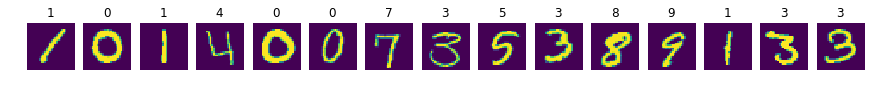

In [39]:
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X[i].reshape((28,28)))
    ax1[i].axis('off')
    ax1[i].set_title(Y[i])

Nous pouvons voir que certains nombres sont difficilement reconnaissable à l'oeil humain, le style d'écriture est de plus différent, certain nombre sont plus plus épais que d'autres

#### Répartition des labels

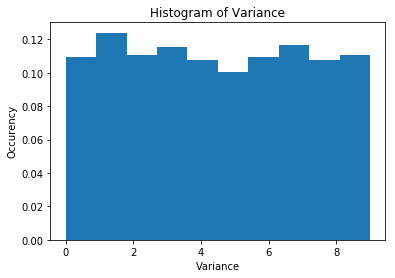

In [35]:
plt.hist(Y, )
plt.title("Histogram of Variance")
plt.xlabel("Variance")
plt.ylabel("Occurency")
plt.show()

#### Représentation de la variance

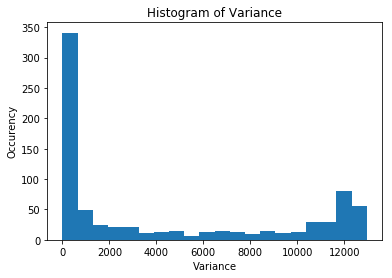

In [26]:
variance_hist = np.var(X, axis = 0)
plt.hist(variance_hist, 20)
plt.title("Histogram of Variance")
plt.xlabel("Variance")
plt.ylabel("Occurency")
plt.show()

#### PCA pour la visualisation de données

L'utilité de la réduction de dimensionnalité peut ne pas être entièrement évidente dans deux dimensions seulement, mais devient beaucoup plus claire lorsque l'on regarde des données de grande dimension. Dans notre cas nous sommes en dimension 784, cela est donc difficile de visualiser nos données dans l'ensemble. L'utilité de PCA dans un premier temps est de nous permettre de retourner en dimension 2 pour visualiser nos données. 

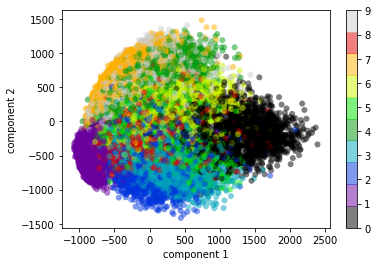

In [27]:
pca_vizualise = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X)

plt.scatter(projected[:, 0], projected[:, 1],
            c=Y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()


les données complètes sont un nuage de points de 784 dimensions, et ces points sont la projection de chaque point de données le long des directions présentant la variance la plus grande. Pour l'essentiel, nous avons trouvé l'étirement et la rotation optimaux dans un espace à 784 dimensions qui nous permet de voir la disposition des chiffres en deux dimensions, et ce, de manière non supervisée, c'est-à-dire sans référence aux étiquettes.

## 2. Dimensionality Reduction using PCA

Une des applications les plus importantes de la PCA est d’accélérer les algorithmes d’apprentissage automatique.

In [0]:
from sklearn.decomposition import PCA
# ## Removing the column with variance 0
variance = np.var(X, axis = 0)>1000
print(variance.shape)
X = X[:, variance]
Test = Test[:,variance]
print(X.shape)
# ##Calculate Principal Components
pca = PCA()
pca.fit(X)

#### a. Plot graph of component vs. cumulative explained variance .
This graph will help us in choosing the no of components for training our data.

Une partie vitale de PCA est d’estimer le nombre de composants nécessaire à la description des données pour l’utilisation concrète de PCA. Ceci peut être déterminé en examinant le ratio de variance expliquée cumulative en fonction du nombre de composants:

(784,)
(42000, 412)


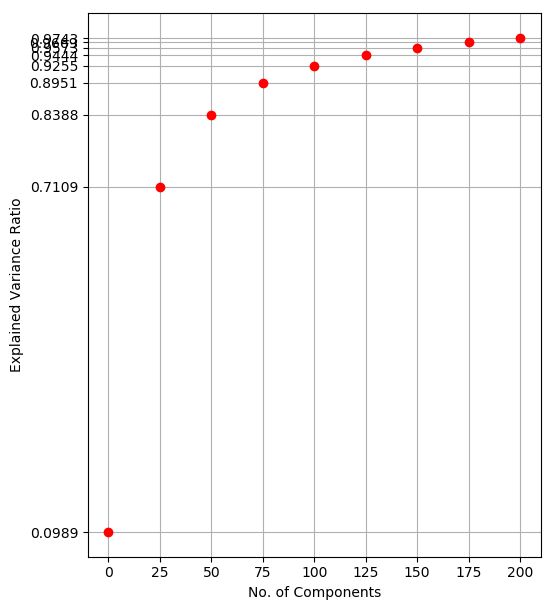

In [5]:

explained_variance = pca.explained_variance_ratio_
# ##Calculate cumulative explained ration
cum_explained_variance = [np.sum(explained_variance[:i+1]) for i in range (0, 201, 25)]
X_axis = [i for i in range(0, 201,25)]

##Plot Graph
fig = plt.figure(figsize = (5.841, 7.195), dpi=100)
plt.plot(X_axis, cum_explained_variance, 'ro')
plt.grid(True, which = 'both')
plt.yticks(cum_explained_variance)
plt.xticks(X_axis)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("No. of Components")
plt.show()

Cette courbe quantifie la part de la variance totale à 784 dimensions contenue dans les N premières composantes. Par exemple, nous voyons qu'avec les chiffres, les 25 premiers composants contiennent environ 75% de la variance, alors qu'il nous faut environ 175 composants pour décrire près de 100% de la variance.

Nous voyons ici que notre projection bidimensionnelle perd beaucoup d’informations (mesurée par la variance expliquée) et qu’il nous faudrait environ 75 composantes pour conserver 90% de la variance. L'analyse de ce graphique pour rechercher un jeu de données de grande dimensions aide à comprendre le niveau de redondance présent dans plusieurs observations.

**So Looking on the above graph, 50 components comprise 80% variance. So first we will go with 50 componets**

### Splitting data for training and testing
- Training data: 80%
- Test data: 20%

In [46]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size  = 0.20, random_state  = 0)

### define normalize function for normalizing the data, PrincipalComponents function to return top n principal components.

In [54]:

def normalize(sigma2, mean2, X):
    X = (X-mean2)/sigma2
    return X

def PolynomialFeatures1(X):
    X_2 = np.square(X)
    X = np.column_stack((X, X_2))
    return X

J1 = []
J2 = []

##Take n principal components
def PrincipalComponents(n):
    pca = PCA(n_components= n)
    X_train1 = pca.fit_transform(X_train)
    X_test1 = pca.transform(X_test)
    return X_train1, X_test1

## Logistic Regression

def LogisticRegression(X_train2, y_train2, X_test2, y_test2, penalty):
    print("penalty= ", penalty)
    regr = linear_model.LogisticRegression(solver='lbfgs',max_iter=1000, C=penalty)
    regr.fit(X_train2, y_train2)
    score1 = regr.score(X_train2, y_train2)
    score2 = regr.score(X_test2, y_test2)
    print(score1, score2)
    Prediction = regr.predict(X_test2)
    print(len(Prediction))
    return score1, score2, Prediction


**So usually variance of 0.8 is sufficient to explain the variation in data, so we will first train data by taking the top n principal components which can explaine the variance of 0.8**

penalty=  0.1
0.895255237238 0.899404761905
8400
penalty=  0.1
0.89595832752 0.898095238095
8400
penalty=  0.1
0.897004478066 0.900714285714
8400
penalty=  0.1
0.895759356761 0.899523809524
8400
penalty=  0.1
0.895773239491 0.900119047619
8400
penalty=  0.1
0.895749245482 0.899285714286
8400
penalty=  0.1
0.896382883349 0.900476190476
8400
penalty=  0.1
0.895937838104 0.899404761905
8400
penalty=  0.1
0.895972000875 0.899523809524
8400
penalty=  0.1
0.89534640757 0.899404761905
8400


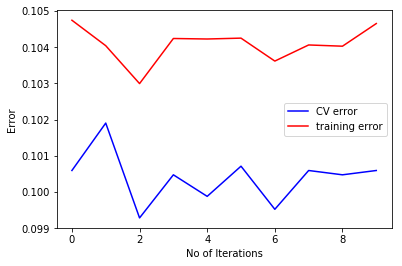

NameError: name 'score' is not defined

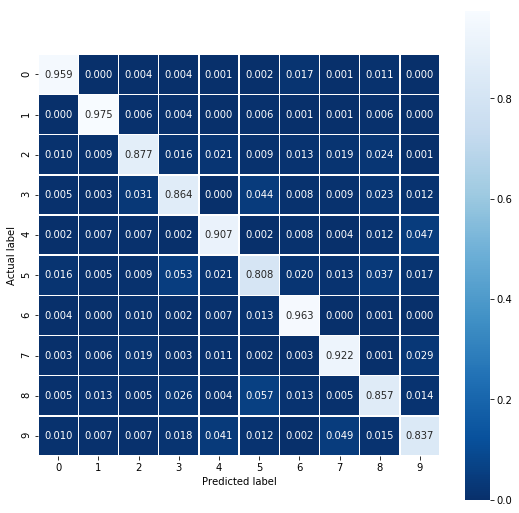

In [58]:
X_train1, X_test1 = PrincipalComponents(0.8)   # Getting principal components
J1 = []
J2 = []
P = []
for i in range(20000, X_train1.shape[0], 1500):
    score1, score2, Prediction = LogisticRegression(X_train1[:i+1,:], y_train[:i+1, ], 
                                                    X_test1[:i+1,:], y_test[:i+1], 0.1)
    J1.append(1-score1)
    J2.append(1-score2)
    P = Prediction
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, P)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
plt.title(all_sample_title, size = 15);



- We got a very irregular graph and not a satisfied accuracy and the accuracy doesn't increase with the increaing training data. So it seems that we are suffering from a high bias. Let us try to train data with top n components explaining the variance of 0.9

In [0]:
X_train1, X_test1 = PrincipalComponents(0.9)
J1 = []
J2 = []
for i in range(20000, X_train1.shape[0], 1500):
    score1, score2, Prediction = LogisticRegression(X_train1[:i+1,:],
                                                    y_train[:i+1, ], X_test1[:i+1,:], y_test[:i+1],0.1)
    J1.append(1-score1)
    J2.append(1-score2)
    
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()

** We can see that accuracy didn't increase much so it doesn't seems a gud idea. Let us again take top n components explaining the variance of 0.8 and also include thieir polynomials(degree = 2)**.

#### Add polynomial features

##### 1.Logistic Regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(include_bias = False)
X_train1, X_test1 = PrincipalComponents(0.81)
print(X_test1.shape, X_train1.shape)

X_train1 = poly.fit_transform(X_train1)
X_test1 = poly.transform(X_test1)

print(X_test1.shape, X_train1.shape)

sigma = np.std(X_train1, axis = 0)
mean = np.mean(X_train1, axis = 0)

X_train1 = normalize(sigma , mean , X_train1)
X_test1 = normalize(sigma , mean, X_test1)

J1 = []
J2 = []
for i in range(25000, X_train1.shape[0], 1500):
    score1, score2, Prediction = LogisticRegression(X_train1[:i+1,:], 
                                                    y_train[:i+1, ], X_test1[:i+1,:], y_test[:i+1],0.1)
    J1.append(1-score1)
    J2.append(1-score2)
    
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()

** We got way better accuracy here and is data over  fitting .... may be but since we are getting good result on cross validation data also, It's gud to go with this.**

#### Saving data trained with logistic regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(include_bias = False)

X1 = X.copy()
Test1 = Test.copy()

pca = PCA(n_components= 0.8388)
X1 = pca.fit_transform(X1)
Test1 = pca.transform(Test)

print(X1.shape, Test1.shape)

X1 = poly.fit_transform(X1)
Test1 = poly.fit_transform(Test1)

print(X1.shape, Test1.shape)

sigma = np.std(X1, axis = 0)
mean = np.mean(X1, axis = 0)

X1 = normalize(sigma, mean, X1)
Test1 = normalize(sigma , mean, Test1)
print(X1.shape, Test1.shape)


regr = linear_model.LogisticRegression(solver='lbfgs',max_iter=1000, C=0.1)
regr.fit(X1, Y)
score1 = regr.score(X1, Y)
print(score1)
Prediction = regr.predict(Test1)
image_id = np.arange(1,Prediction.shape[0]+1)
pd.DataFrame({"ImageId": image_id, "Label": Prediction}).to_csv('out_reg1.csv', 
                                                                      index=False, header=True)

#### I submitted the data and got an accuracy of 0.9815. Now we will try to train data with SVM and kernel = 'rbf'. Note we will not use polynomial features with SVM since SVM maps the data in higher dimensions so there is no point in including the polynomial features, also SVM doesn't perform well with too many features.

##### 2.SVM

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

def supportVM(X_train2, y_train2, X_test2, y_test2, penalty):
    regr = SVC(kernel ='rbf', C=penalty)
    regr.fit(X_train2, y_train2)
    score1 = regr.score(X_train2, y_train2)
    score2 = regr.score(X_test2, y_test2)
    print(score1, score2)
    Prediction = regr.predict(X_test2)
    return score1, score2, Prediction

X_train1, X_test1 = PrincipalComponents(0.81)
print(X_test1.shape, X_train1.shape)

sigma = np.std(X_train1, axis = 0)
mean = np.mean(X_train1, axis = 0)

X_train1 = normalize(sigma , mean , X_train1)
X_test1 = normalize(sigma , mean, X_test1)

J1 = []
J2 = []
for i in range(25000, X_train1.shape[0], 1500):
    score1, score2, Prediction = supportVM(X_train1[:i+1,:], 
                                                    y_train[:i+1, ], X_test1[:i+1,:], y_test[:i+1],10)
    J1.append(1-score1)
    J2.append(1-score2)
    
plt.plot(J2, 'b-', label = "CV error")
plt.plot(J1, 'r-', label ="training error")
plt.legend()
plt.ylabel("Error")
plt.xlabel("No of Iterations")
plt.show()

- So it seems that this model is performin a little bit better, So we will go with it, Let's save the prediction and save it.

##### Saving prediction trained with SVM

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
# poly = PolynomialFeatures(include_bias = False)

X1 = X.copy()
Test1 = Test.copy()

pca = PCA(n_components= 0.8388)
X1 = pca.fit_transform(X1)
Test1 = pca.transform(Test)

print(X1.shape, Test1.shape)

print(X1.shape, Test1.shape)

sigma = np.std(X1, axis = 0)
mean = np.mean(X1, axis = 0)

X1 = normalize(sigma, mean, X1)
Test1 = normalize(sigma , mean, Test1)
print(X1.shape, Test1.shape)


regr = SVC(kernel ='rbf', C=10)
regr.fit(X1, Y)
score1 = regr.score(X1, Y)
print(score1)
Prediction = regr.predict(Test1)
Prediction = regr.predict(Test1)
image_id = np.arange(1,Prediction.shape[0]+1)
pd.DataFrame({"ImageId": image_id, "Label": Prediction}).to_csv('out_svm.csv', 
                                                                      index=False, header=True)

** I got an accuracy of 0.98442 on leaderboad with above model**.
I am learning CNN, So in future I will use that to train data and most probably I will launch a kernel also .Please give your valuable feedback.